In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [14]:
df = pd.read_csv('../base/heart.csv')
print(df.columns)

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


Visualize os dados

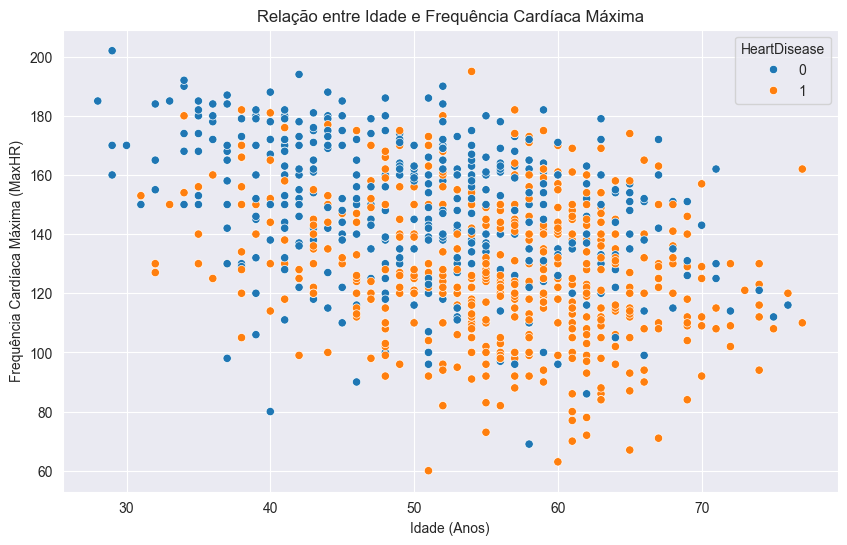

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Age"], y=df["MaxHR"], hue=df["HeartDisease"])

plt.title("Relação entre Idade e Frequência Cardíaca Máxima")
plt.xlabel("Idade (Anos)")
plt.ylabel("Frequência Cardíaca Máxima (MaxHR)")

plt.show()

Corrigir os valores de zero

In [16]:
# Colunas com valores de zero que são clinicamente impossíveis
cols_to_correct = ["RestingBP", "Cholesterol"]

# Substituir 0 por NaN (Not a Number) para que possamos calcular a mediana corretamente
for col in cols_to_correct:
    df[col] = df[col].replace(0, np.nan)

# Calcular a mediana de cada coluna (ignorando os NaN) e preencher os valores faltantes
for col in cols_to_correct:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

print("Valores nulos após a correção:")
print(df[cols_to_correct].isnull().sum())
print("\nNovas estatísticas descritivas:")
print(df[cols_to_correct].describe())

Valores nulos após a correção:
RestingBP      0
Cholesterol    0
dtype: int64

Novas estatísticas descritivas:
        RestingBP  Cholesterol
count  918.000000   918.000000
mean   132.538126   243.204793
std     17.990127    53.401297
min     80.000000    85.000000
25%    120.000000   214.000000
50%    130.000000   237.000000
75%    140.000000   267.000000
max    200.000000   603.000000


Etapa 1: Aplicar o One-Hot Encoding

In [17]:
# Primeiro, identificamos as colunas que são realmente categóricas
# Note que não incluímos a variável alvo 'HeartDisease'
categorical_features = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

# Usamos pd.get_dummies para criar as novas colunas
# drop_first=True: Remove a primeira categoria de cada feature. Isso evita redundância (multicolinearidade).
# dtype=int: Cria as novas colunas com 0s e 1s em vez de True/False.
df_encoded = pd.get_dummies(
    df, columns=categorical_features, drop_first=True, dtype=int
)

print("Colunas do DataFrame após o One-Hot Encoding:")
print(df_encoded.columns)
print("\nPrimeiras linhas do novo DataFrame:")
print(df_encoded.head())

Colunas do DataFrame após o One-Hot Encoding:
Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

Primeiras linhas do novo DataFrame:
   Age  RestingBP  Cholesterol  MaxHR  Oldpeak  HeartDisease  Sex_M  \
0   40      140.0        289.0    172      0.0             0      1   
1   49      160.0        180.0    156      1.0             1      0   
2   37      130.0        283.0     98      0.0             0      1   
3   48      138.0        214.0    108      1.5             1      0   
4   54      150.0        195.0    122      0.0             0      1   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  FastingBS_1  \
0                  1                  0                 0            0   
1                  0                  1     

Etapa 2: Nova Seleção de Recursos e Divisão
Seleção de recurso

- Variáveis independentes (features):
São as colunas que você usa como base para prever a target.

- Variável dependente (target):
A variável que você quer prever — neste caso, se a pessoa tem ou não doença cardíaca

In [18]:
X = df_encoded.drop("HeartDisease", axis=1)  # remove a coluna target, fica só com as features
y = df_encoded["HeartDisease"]  # pega só a coluna target para prever

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=16
)

# Aplicamos a padronização
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

Otimização do Hiperparâmetro K para o KNN

In [19]:
#  Defina a grade de parâmetros para testar
#  Para o KNN, o principal é o 'n_neighbors' (k)
param_grid_knn = {
    "n_neighbors": range(1, 31)
}

#  Crie o objeto GridSearchCV
#  - scoring: a métrica do projeto ('f1_weighted' ou 'balanced_accuracy')
#  - cv: 5 folds
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,  # Acelera o processo
)

#    Treine o GridSearchCV com os dados de treino padronizados
#    (Use o X_train_scaled e y_train da divisão inicial)
grid_search_knn.fit(X_train_scaled, y_train)

best_k = grid_search_knn.best_params_["n_neighbors"]
print(f"Melhor 'k' encontrado pelo GridSearchCV: {best_k}")

best_knn_model = KNeighborsClassifier(n_neighbors=best_k)

Melhor 'k' encontrado pelo GridSearchCV: 13


In [20]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(X_train_scaled, y_train)
y_pred_best_knn_model = best_knn_model.predict(X_test_scaled)

f1 = f1_score(y_test, y_pred_best_knn_model, average="weighted")

balanced_acc = balanced_accuracy_score(y_test, y_pred_best_knn_model)

print(f"Avaliação do Modelo KNN com k={best_k}:")
print("=" * 40)
print(f"Acurácia Balanceada: {balanced_acc:.4f}")
print(f"F1-Score (Ponderado): {f1:.4f}")
print("=" * 40)

print("Relatório de Classificação Detalhado:")
print(
    classification_report(y_test, y_pred_best_knn_model, target_names=["Sem Doença", "Com Doença"])
)

Avaliação do Modelo KNN com k=13:
Acurácia Balanceada: 0.8618
F1-Score (Ponderado): 0.8645
Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

  Sem Doença       0.90      0.81      0.85       108
  Com Doença       0.84      0.92      0.88       122

    accuracy                           0.87       230
   macro avg       0.87      0.86      0.86       230
weighted avg       0.87      0.87      0.86       230



In [21]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_best_knn_model)
cnf_matrix

array([[ 87,  21],
       [ 10, 112]], dtype=int64)

In [22]:

y_pred_proba = best_knn_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

dados = {"name_model":"KNN", "fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": float(auc)},
import json
path = '../roc_auc_data.json'
with open(path, "r", encoding="utf-8") as f:
    read_data = json.load(f)

read_data["knn_roc_auc"] = dados

with open(path, "w", encoding="utf-8") as f:
    json.dump(read_data, f, indent=4, ensure_ascii=False)

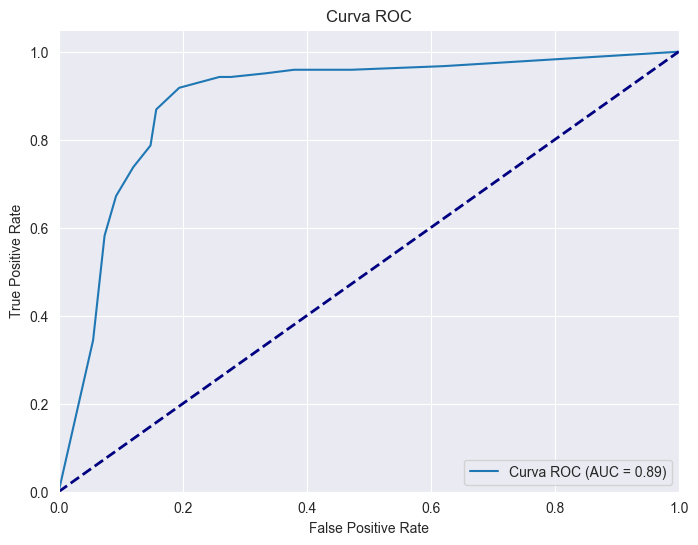

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {auc:.2f})")
plt.plot(
    [0, 1], [0, 1], color="navy", lw=2, linestyle="--"
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(visible=True)
plt.show()

In [24]:
print(f"Iniciando a validação robusta com k={best_k}")

# Métrica a ser usada ('f1_weighted' ou 'balanced_accuracy')
METRICA_ESCOLHIDA = "f1_weighted"

metric_scores_means = []

N_REPETICOES = 30

for i in range(N_REPETICOES):
    #  Divida os dados com um random_state diferente a cada iteração
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=i
    )

    #  Padronize os dados DENTRO do loop
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    #  Execute a validação cruzada com 5 folds no conjunto de TREINO
    scores = cross_val_score(
        estimator=best_knn_model,
        X=X_train_scaled,
        y=y_train,
        cv=5,
        scoring=METRICA_ESCOLHIDA,
    )

    metric_scores_means.append(scores.mean())
    # print(
    #     f"Execução {i + 1}/{N_REPETICOES} | Média da {METRICA_ESCOLHIDA}: {scores.mean():.4f}"
    # )
formatted_scores = [f"{score}" for score in metric_scores_means]
print(formatted_scores)
mean_of_means = np.mean(metric_scores_means)
std_of_means = np.std(metric_scores_means)

print("\n" + "=" * 50)
print("Resultado Final após 30 Execuções da Validação Cruzada 5-Fold")
print("=" * 50)
print(f"Modelo: KNN com k={best_k}")
print(f"Métrica utilizada: {METRICA_ESCOLHIDA}")
print(f"Média das médias dos scores: {mean_of_means:.4f}")
print(f"Desvio padrão das médias dos scores: {std_of_means:.4f}")
print("=" * 50)

Iniciando a validação robusta com k=13
['0.8746615446823132', '0.8525625388412893', '0.8672578111509308', '0.8421984683868351', '0.8601222466205549', '0.8555436259777507', '0.8630277150311487', '0.8585527067661836', '0.8627917367237512', '0.8440955007340781', '0.8550791509217721', '0.8730169044988578', '0.8613817795705284', '0.8510493150385188', '0.8632620743412538', '0.8627711833496032', '0.8702255709825621', '0.8439259279902878', '0.8716677239766077', '0.8557779969387325', '0.8580819301895865', '0.861342224976819', '0.8456221379684917', '0.8672709524953536', '0.8597095540596424', '0.8580242574406703', '0.8586545642256003', '0.8509094535342936', '0.8439794064081602', '0.8624529130433161']

Resultado Final após 30 Execuções da Validação Cruzada 5-Fold
Modelo: KNN com k=13
Métrica utilizada: f1_weighted
Média das médias dos scores: 0.8585
Desvio padrão das médias dos scores: 0.0087
